In [11]:
!python3 -m pip install bioread
!python3 -m pip install heartpy
!python3 -m pip install neurokit2



[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.2/689.2 kB 3.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 11.0 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 9.3 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: pip3 install --upgrade pip


"""
The method sends a signal according to the scenario given, to the serial port, then zero-s it back and closes the port.
List of scenarios:
    
    255 - Initialization
    80 - Startle Habituation
    99 - Calibration (Staring at the + for a minute)

    Scenarios List indexing method:
    First digit (left):
        0 - N
        1 - P
        2 - U
    Second digit:
        1 - Condition Start
        2 - Cue Start
        3 - No-Cue Start
    Third digit:
        0 - Onset
        1 - Startle
        2 - Shock
"""

In [1]:
import bioread
import numpy as np
import pandas as pd
import heartpy as hp
import neurokit2 as nk
from matplotlib import pyplot as plt
from pathlib import Path
from datetime import datetime

In [2]:
acq_file = bioread.read_file(r'../Assignments/80_28.1.24 (NPU_template).acq')

In [3]:
def file_to_df(acq_file):
    data = {}
    data['ECG - ECG100C'] = np.asarray(acq_file.named_channels['ECG - ECG100C'].data)
    # The dtype value is because of an error in the endianess of the CPU, might need to delete on other PCs
    data['C5 - Expression'] = np.asarray(acq_file.named_channels['C5 - Expression'].data, dtype='<u4')
    
    return pd.DataFrame(data)

In [4]:
def prepare_df(df):
    df = df.dropna()
    df = df.reset_index(drop=True)

    non_zero_indices = df.index[df['C5 - Expression'] != 0]
    index_rows_to_change = []
    for i in range(len(non_zero_indices)-1):
        if non_zero_indices[i+1] == non_zero_indices[i]+1:
            index_rows_to_change.append(non_zero_indices[i])
    for index in index_rows_to_change:
        df.loc[index, 'C5 - Expression'] = 0
    
    return df

In [5]:
df = file_to_df(acq_file)
df = prepare_df(df)
print(df)

         ECG - ECG100C  C5 - Expression
0             0.000000                0
1             0.000153                0
2            -0.000153                0
3             0.000000                0
4             0.000000                0
...                ...              ...
3132788      -0.097656                0
3132789      -0.100098                0
3132790      -0.102539                0
3132791      -0.105438                0
3132792      -0.109253                0

[3132793 rows x 2 columns]


In [6]:
def extract_ecg_values(df, expression_to_extract, window_ms):
    """
    returns the indices where the 'C5 - Expression' is equal to expression_to_extract, plus the next 2*window_ms indices
    for example, if index 31, 1000, 1005 are the correct expression, and window_ms is 10, the function will return indices
    31-51, 1000-1025
    """
    df_baseline = df[df['C5 - Expression']==expression_to_extract]

    df_baseline_window = pd.DataFrame()
    for index in df_baseline.index:
        df_slice = df['ECG - ECG100C'].iloc[index : index + (2 * window_ms)]
        df_slice = df_slice.to_frame(name='ECG - ECG100C')
        df_baseline_window = pd.concat([df_baseline_window, df_slice])
    return df_baseline_window

In [7]:
def split_df_into_segments(df):
    """
    Splits the df into different segments by the non zero expression indices
    """
    dfs = []
    non_zero_indices = df[df['C5 - Expression']!=0].index
    for i in range(len(non_zero_indices) - 1):
        base = non_zero_indices[i]
        end = non_zero_indices[i+1]
        df_slice = df.iloc[base : end]
        dfs.append(df_slice)

    # Handling the last non zero index
    base = non_zero_indices[-1]
    df_slice = df.iloc[base : ]
    dfs.append(df_slice)

    return dfs

In [8]:
dfs = split_df_into_segments(df)

In [9]:
def ecg_process_df(df, should_print=True):
    flattened_df = df['ECG - ECG100C'].values.flatten()
    signals, info = nk.ecg_process(flattened_df, 2000)
    heart_rate = signals['ECG_Rate']
    if should_print:
        print(signals)
        print(heart_rate)
    return signals, info, heart_rate

def hrv_metrics(info, should_print=True):
    rPeaks = info['ECG_R_Peaks']
    metrics = nk.hrv(rPeaks, sampling_rate=2000, show=True)
    if should_print:
        print(metrics)
    return metrics

In [10]:
def process_dfs(dfs):
    base_dir_name = '../DataAnalysis/outputs/' + datetime.now().strftime("%d-%m-%Y %H-%M-%S")
    for i in range(len(dfs)):
        df = dfs[i]
        try:
            expression = int(df.iloc[0]['C5 - Expression'])
            dir_name = base_dir_name + "/" + str(i + 1) + "_" + str(expression)
            signals, info, heart_rate = ecg_process_df(df, should_print=False)
            metrics = hrv_metrics(info, should_print=False)
            Path(dir_name).mkdir(parents=True, exist_ok=True)
            signals.to_csv(dir_name + "/signals.csv")
            heart_rate.to_csv(dir_name + "/heart_rate.csv")
            metrics.to_csv(dir_name + "/metrics.csv")
            plt.savefig(dir_name + "/hrv_plot.png")
        except Exception as e: 
            print("Failed processing df number - " + str(i + 1))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Failed processing df number - 3
Failed processing df number - 4
Failed processing df number - 5
Failed processing df number - 6
Failed processing df number - 7
Failed processing df number - 8
Failed processing df number - 9
Failed processing df number - 10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Failed processing df number - 12
Failed processing df number - 13
Failed processing df number - 14


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Failed processing df number - 15
Failed processing df number - 16


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Failed processing df number - 19
Failed processing df number - 20
Failed processing df number - 21


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Failed processing df number - 23
Failed processing df number - 24
Failed processing df number - 25
Failed processing df number - 26


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Failed processing df number - 27


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Failed processing df number - 29
Failed processing df number - 30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Failed processing df number - 32
Failed processing df number - 33
Failed processing df number - 34


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vect

Failed processing df number - 36
Failed processing df number - 37
Failed processing df number - 38


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Failed processing df number - 40


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Failed processing df number - 42
Failed processing df number - 43
Failed processing df number - 44


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Failed processing df number - 45
Failed processing df number - 46
Failed processing df number - 47


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Failed processing df number - 48


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Failed processing df number - 50
Failed processing df number - 51
Failed processing df number - 52


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/Library/

Failed processing df number - 55
Failed processing df number - 56
Failed processing df number - 57
Failed processing df number - 58
Failed processing df number - 59
Failed processing df number - 60
Failed processing df number - 61


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more informati

Failed processing df number - 63
Failed processing df number - 64
Failed processing df number - 65


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Failed processing df number - 67
Failed processing df number - 68
Failed processing df number - 69
Failed processing df number - 70
Failed processing df number - 71


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Failed processing df number - 72
Failed processing df number - 73
Failed processing df number - 74
Failed processing df number - 75
Failed processing df number - 76


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Failed processing df number - 78
Failed processing df number - 79
Failed processing df number - 80


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Failed processing df number - 81


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Failed processing df number - 83
Failed processing df number - 84
Failed processing df number - 85
Failed processing df number - 86
Failed processing df number - 87
Failed processing df number - 88
Failed processing df number - 89


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vect

Failed processing df number - 91
Failed processing df number - 92
Failed processing df number - 93


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Failed processing df number - 95


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv.py:135: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(constrained_layout=False)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few pea

Failed processing df number - 97
Failed processing df number - 98
Failed processing df number - 99
Failed processing df number - 100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Failed processing df number - 102
Failed processing df number - 103


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Failed processing df number - 105
Failed processing df number - 106
Failed processing df number - 107
Failed processing df number - 108


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


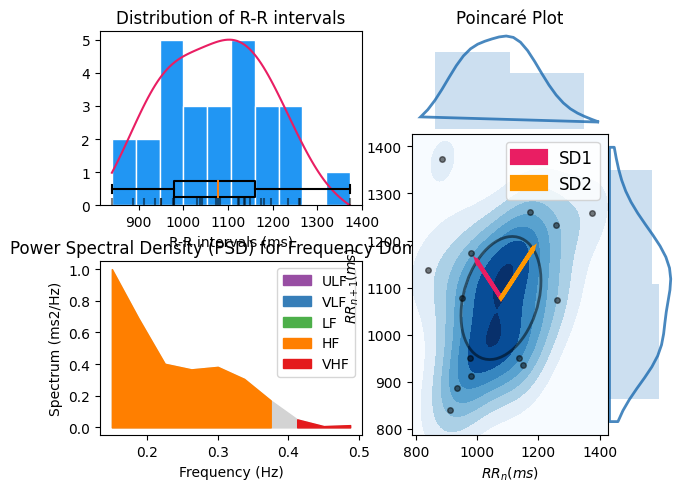

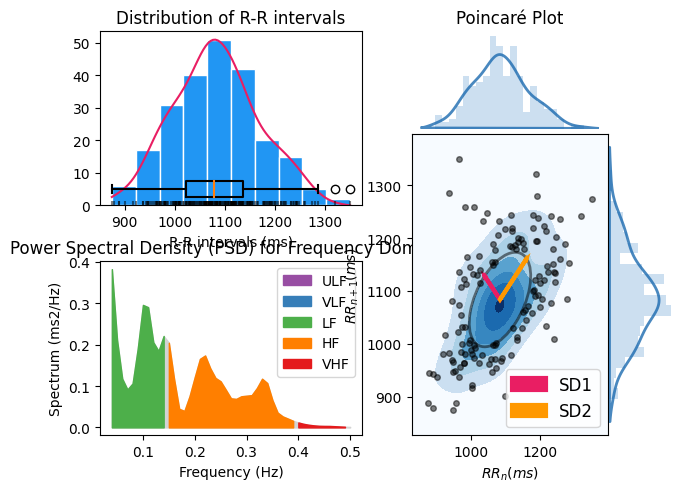

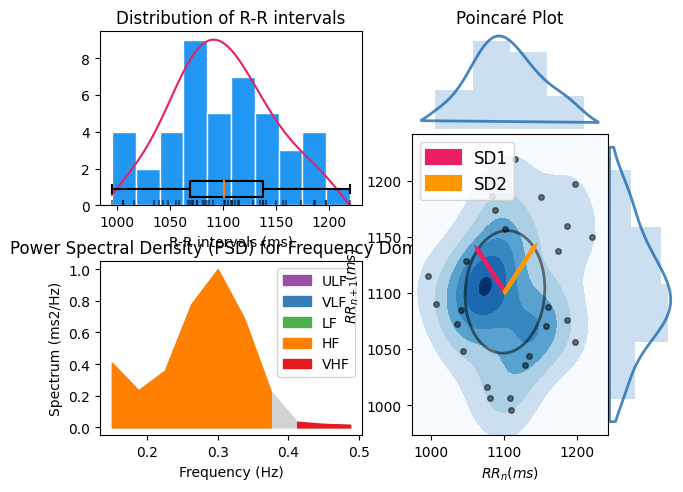

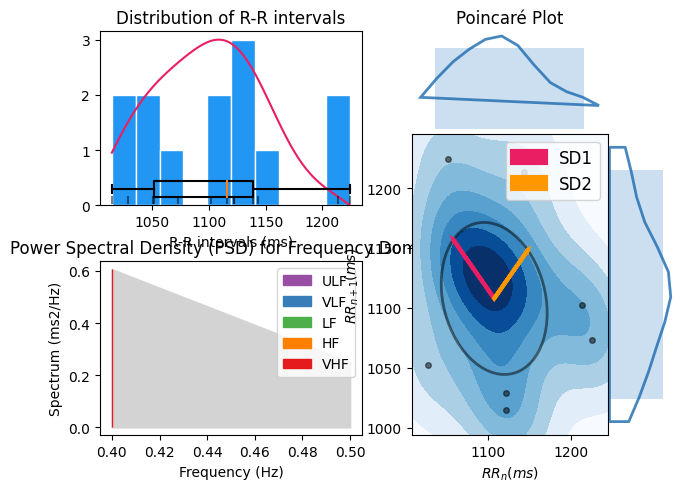

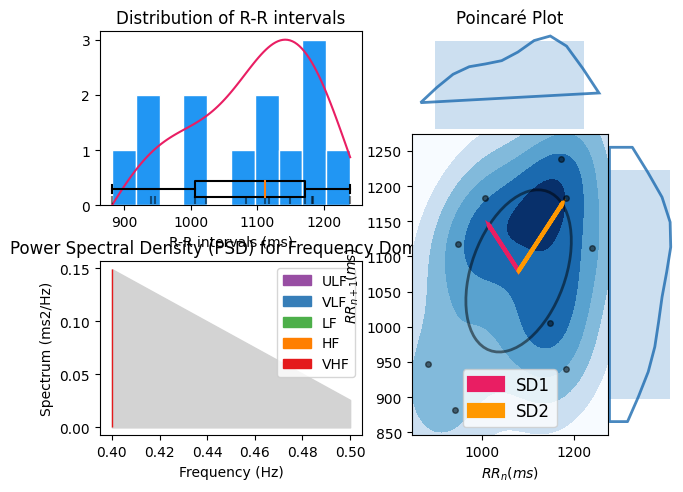

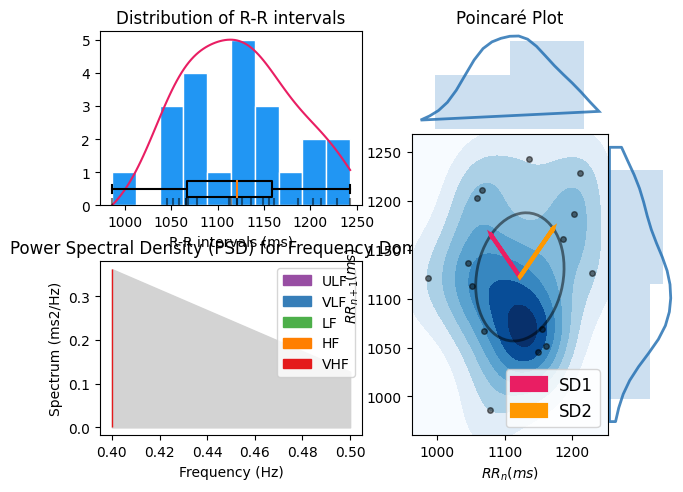

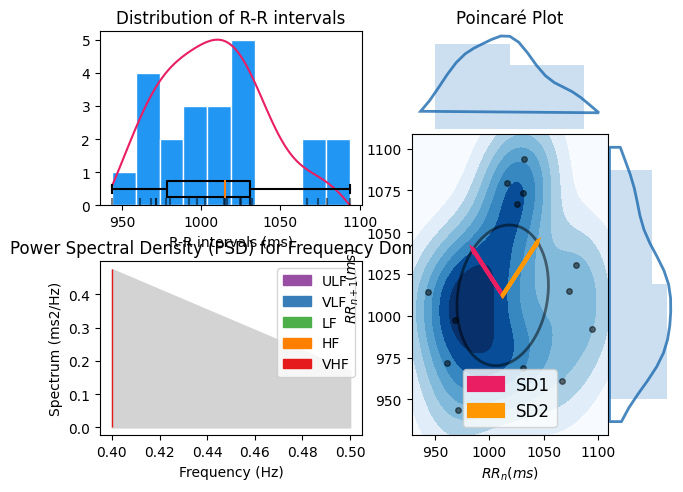

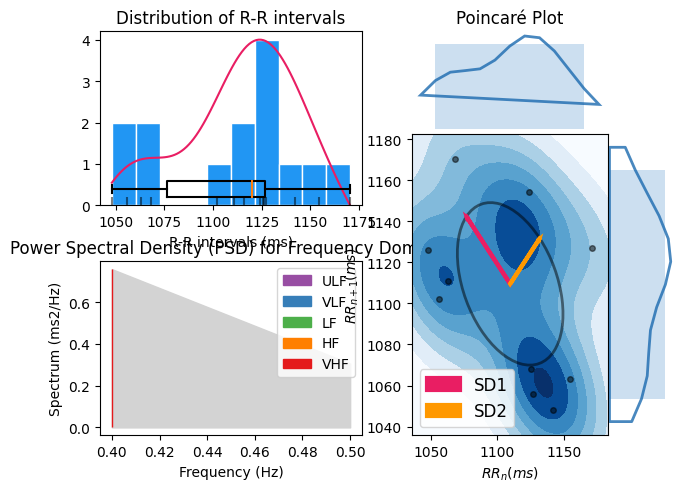

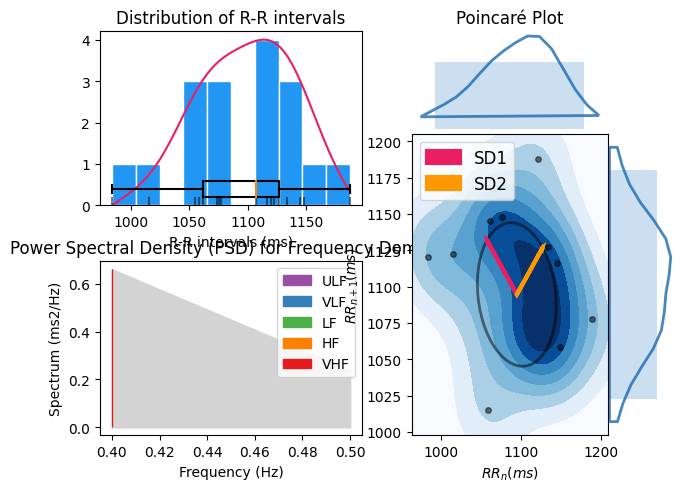

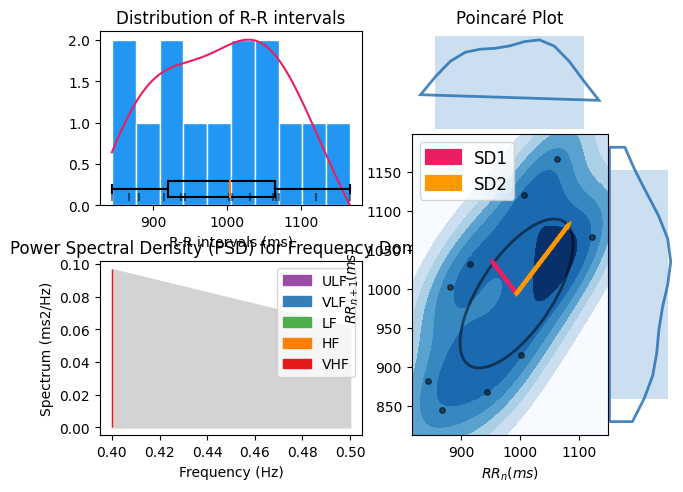

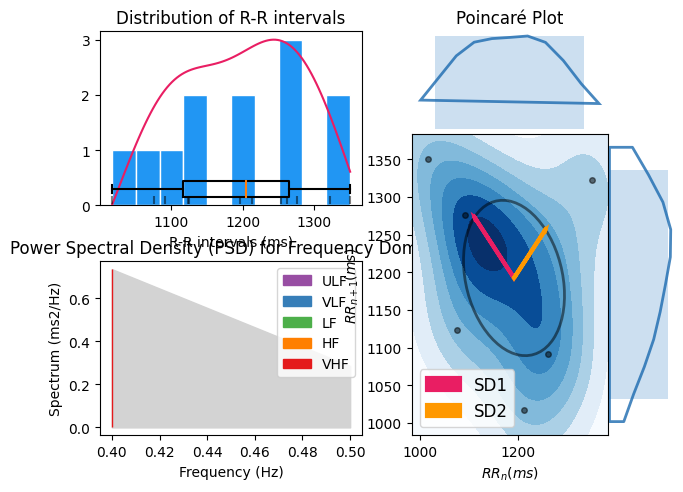

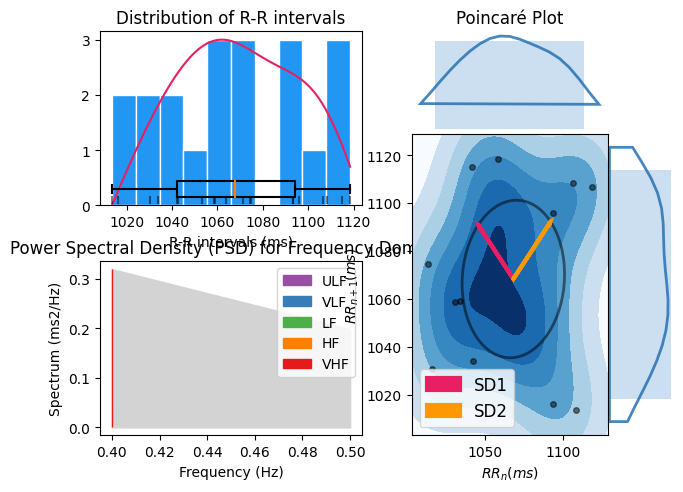

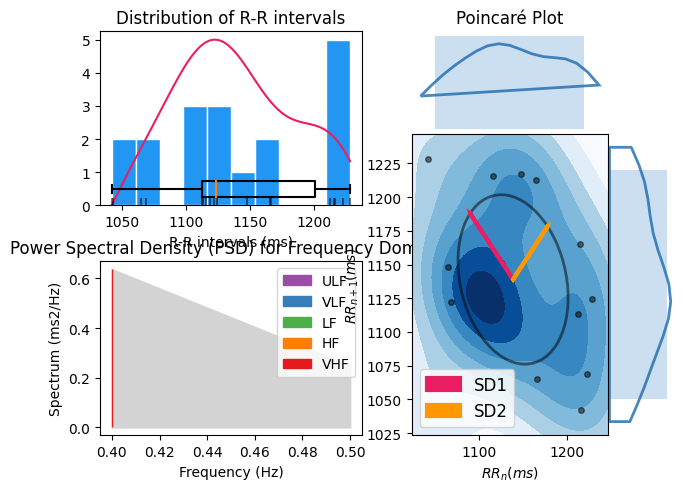

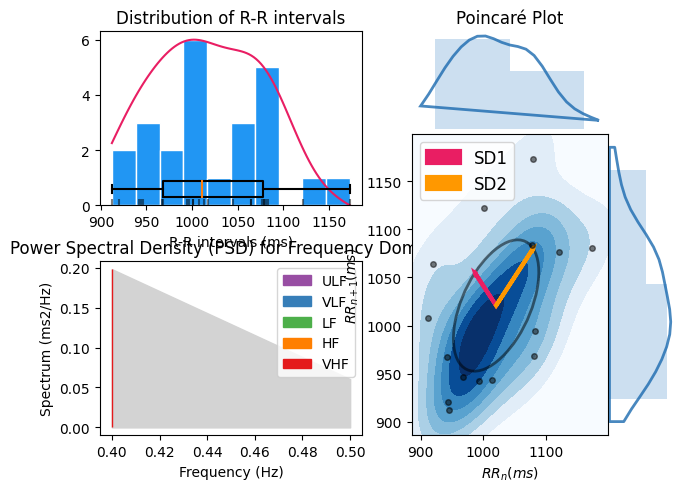

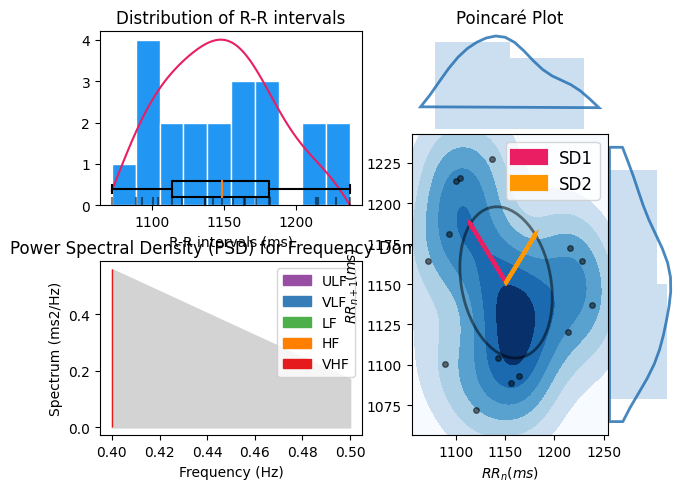

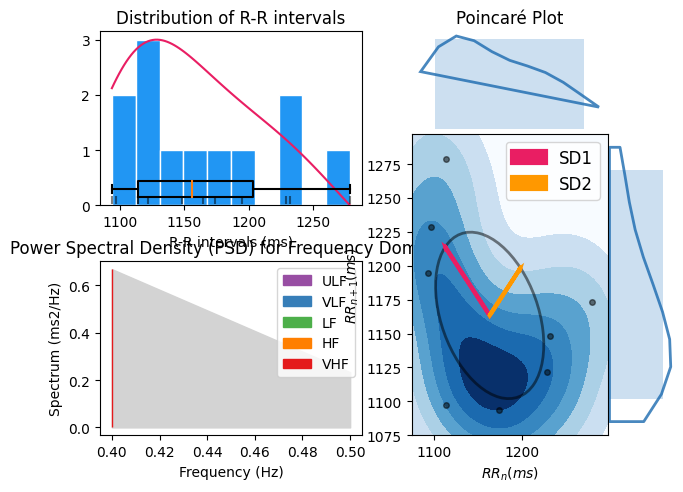

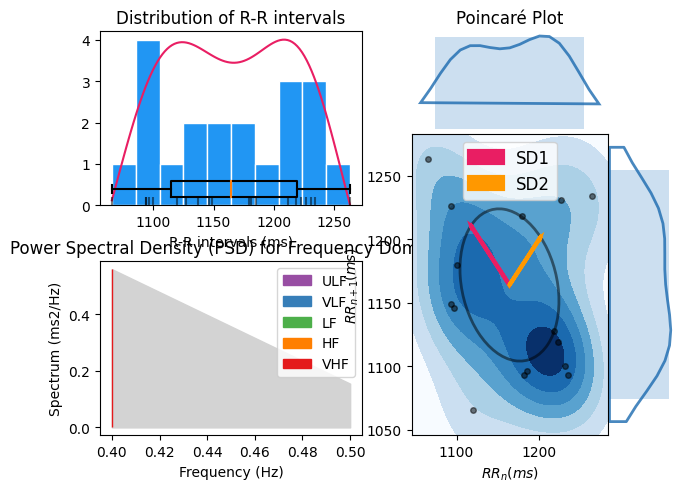

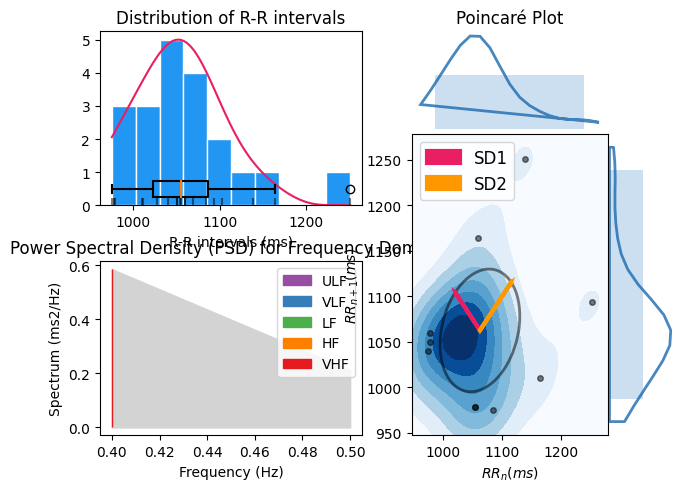

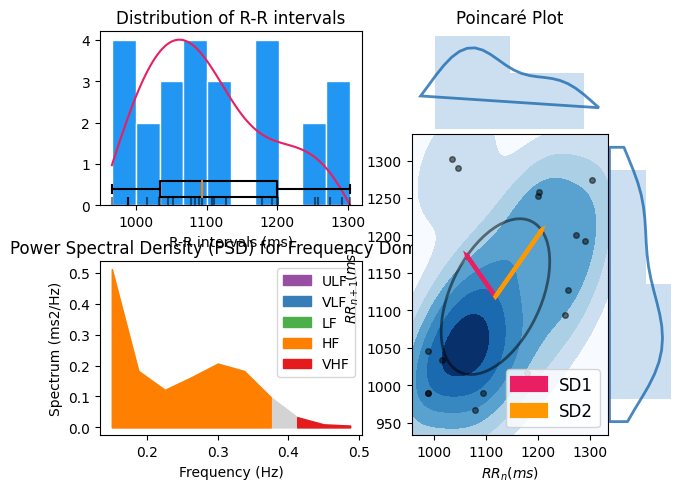

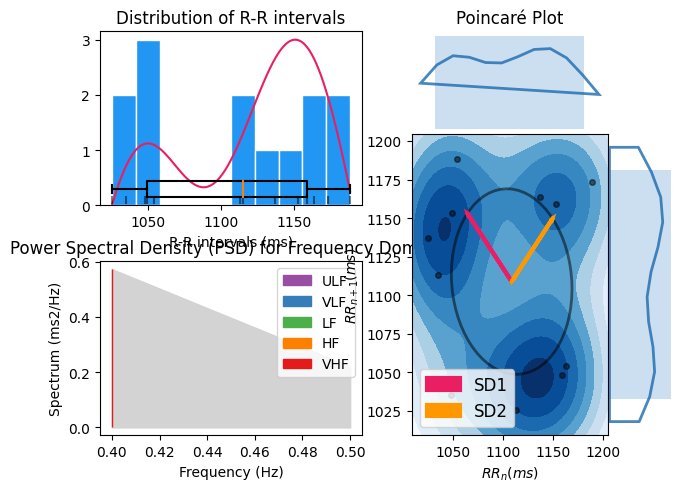

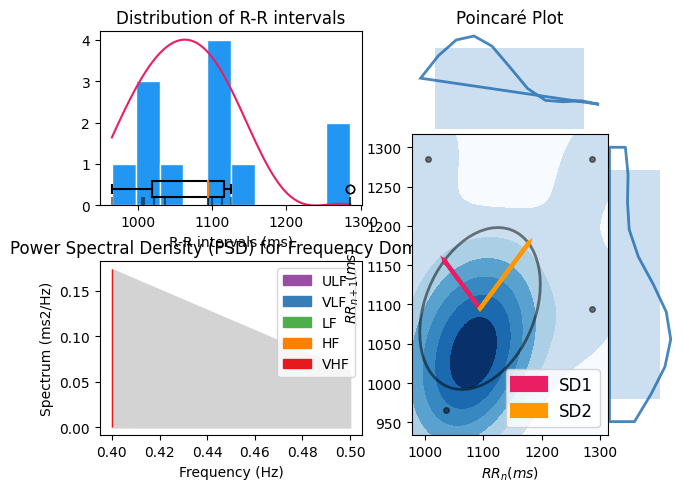

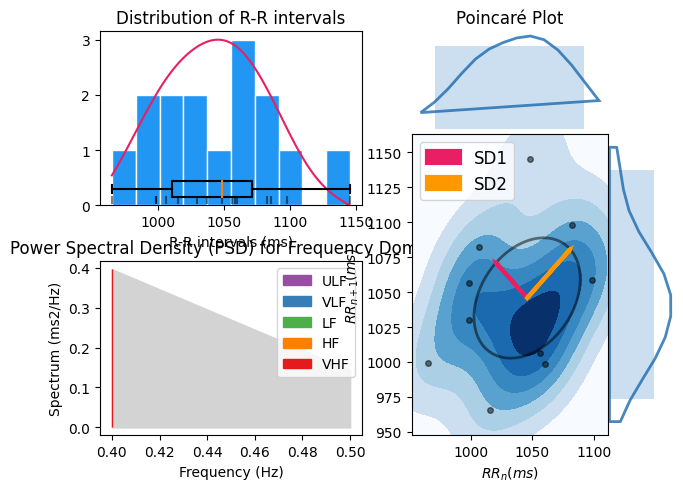

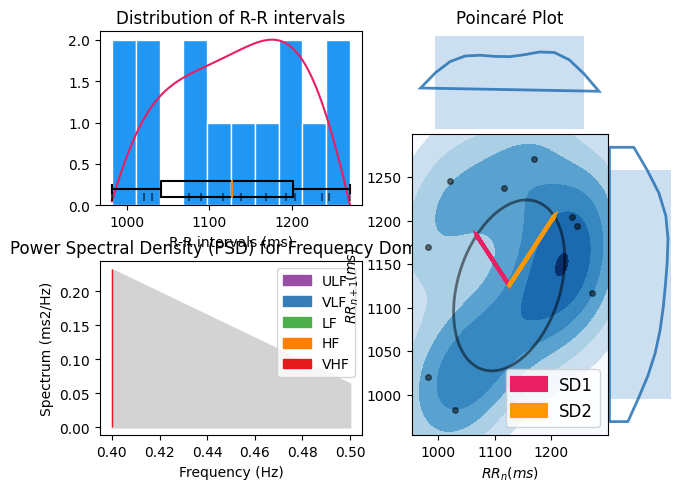

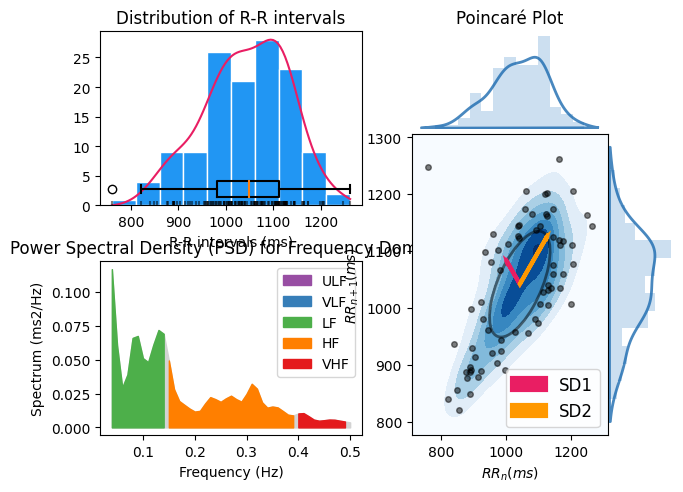

In [11]:
process_dfs(dfs)

In [ ]:
df_30 = extract_ecg_values(df, 30, 1000*60)

          ECG_Raw  ECG_Clean   ECG_Rate  ECG_Quality  ECG_R_Peaks  \
0       -0.008698  -0.007257  55.365730     0.995561            0   
1       -0.008545  -0.006716  55.365730     0.995561            0   
2       -0.007782  -0.006175  55.365730     0.995561            0   
3       -0.007477  -0.005634  55.365730     0.995561            0   
4       -0.006866  -0.005092  55.365730     0.995561            0   
...           ...        ...        ...          ...          ...   
1439995  0.119019   0.012717  54.644809     0.000000            0   
1439996  0.118561   0.012090  54.644809     0.000000            0   
1439997  0.118561   0.011464  54.644809     0.000000            0   
1439998  0.118103   0.010838  54.644809     0.000000            0   
1439999  0.118256   0.010212  54.644809     0.000000            0   

         ECG_P_Peaks  ECG_P_Onsets  ECG_P_Offsets  ECG_Q_Peaks  ECG_R_Onsets  \
0                  0             0              0            0             0   
1          

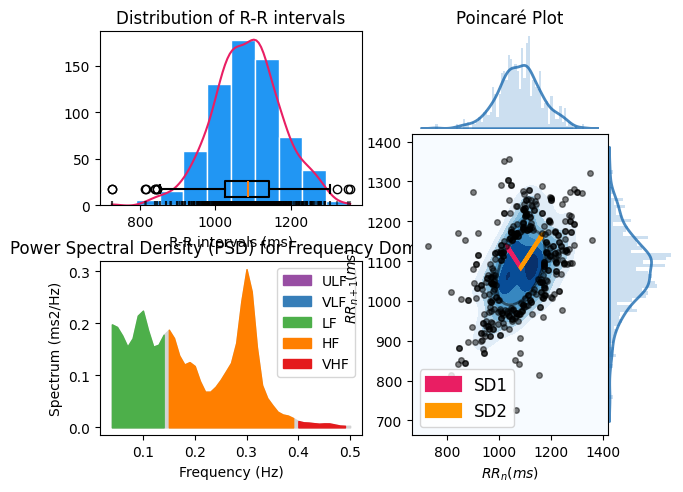

In [ ]:
signals, info, _ = ecg_process_df(df_30)
metrics = hrv_metrics(info)

In [ ]:
df_baseline_minute = pd.DataFrame()
for index in df_baseline.index:
    df_slice = df['ECG - ECG100C'].iloc[index : index + 2000 * 60]
    df_slice = df_slice.to_frame(name='ECG - ECG100C')
    df_baseline_minute = pd.concat([df_baseline_minute, df_slice])
print(df_baseline_minute)

        ECG - ECG100C
481122       0.016327
481123       0.016632
481124       0.017548
481125       0.017548
481126       0.018463
...               ...
601117      -0.069733
601118      -0.070953
601119      -0.071259
601120      -0.072021
601121      -0.072632

[120000 rows x 1 columns]


In [ ]:
ecg_data =  {
    "n_cue": [],
    "n_no_cue": [],
    "p_cue": [],
    "p_no_cue": [],
    "u_cue": [],
    "u_no_cue": []
}
for index, row in df.iterrows():
    value = row['C5 - Expression']
    ecg_value = row['ECG - ECG100C']
    
    
    if value == 020.0:
        ecg_data["n_cue"].append(ecg_value)
    if value == 030.0:
        ecg_data["n_no_cue"].append(ecg_value)
    if value == 120.0:
        ecg_data["p_cue"].append(ecg_value)
    if value == 130.0:
        ecg_data["p_no_cue"].append(ecg_value)
    if value == 220.0:
        ecg_data["u_cue"].append(ecg_value)
    if value == 230.0:
        ecg_data["u_no_cue"].append(ecg_value)
        
max_length = max(len(ecg_data[key]) for key in ecg_data)
for key in ecg_data:
    while len(ecg_data[key]) < max_length:
        ecg_data[key].append(None)
df_ecg = pd.DataFrame(ecg_data)
print(df_ecg)

       n_cue  n_no_cue     p_cue  p_no_cue     u_cue  u_no_cue
0  -0.048065 -0.008698 -0.004578  0.016174  0.102844 -0.026703
1  -0.019684  0.130157 -0.006866 -0.040588  0.067291 -0.094452
2  -0.026398 -0.010529  0.030975 -0.038300 -0.004425 -0.044556
3  -0.152893  0.074768 -0.047150 -0.041046 -0.025482 -0.048828
4  -0.028381  1.200714  0.029297 -0.042725 -0.053406  0.059814
5  -0.014648 -0.022430 -0.019989 -0.561829 -0.009155  0.146790
6   0.114136  0.104828       NaN -0.021210       NaN -0.041046
7  -0.020294  0.016479       NaN -0.087585       NaN -0.053253
8  -0.012054 -0.007782       NaN       NaN       NaN       NaN
9        NaN -0.016785       NaN       NaN       NaN       NaN
10       NaN  0.139313       NaN       NaN       NaN       NaN
11       NaN  0.013428       NaN       NaN       NaN       NaN


In [ ]:
## trying with neurokit   
ecg_sampling_rate = 2000
heart_rate_data = {}
for column in df_ecg.columns:
    signals = nk.ecg_process(df_ecg[column], ecg_sampling_rate)
    heart_rate = nk.ecg_rate(signals)
    heart_rate_data[column] = heart_rate
print("Heart Rates:")
for column, heart_rate in heart_rate_data.items():
    print(f"{column}: {heart_rate.mean()} bpm")

heart_rate_df = pd.DataFrame(heart_rate_data)

mean_heart_rate_per_column = heart_rate_df.mean(axis=0)

print("Mean Heart Rate per column:")
print(mean_heart_rate_per_column)